In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [46]:
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
df = pd.read_csv(data)
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [71]:
df.to_csv("course_lead_scoring.csv", index=False)

## Data preparation

- Check if the missing values are presented in the features.
- If there are missing values:
- For caterogiral features, replace them with 'NA'
- For numerical features, replace with with 0.0

In [47]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [48]:
df.nunique()

lead_source                    5
industry                       7
number_of_courses_viewed      10
annual_income               1267
employment_status              4
location                       7
interaction_count             12
lead_score                   101
converted                      2
dtype: int64

In [49]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

In [50]:
df[categorical] = df[categorical].fillna("NA")
df[numerical] = df[numerical].fillna(0.0)

In [51]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

## Question 1
What is the most frequent observation (mode) for the column industry?

In [52]:
df["industry"].mode()[0]

'retail'

## Question 2

Create the correlation matrix for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features.

What are the two features that have the biggest correlation?

In [53]:
corr_df = round(df[numerical].corr(), 2)
corr_df

,number_of_courses_viewed,annual_income,interaction_count,lead_score
number_of_courses_viewed,1.00,0.01,-0.02,-0.00
annual_income,0.01,1.00,0.03,0.02
interaction_count,-0.02,0.03,1.00,0.01
lead_score,-0.00,0.02,0.01,1.00


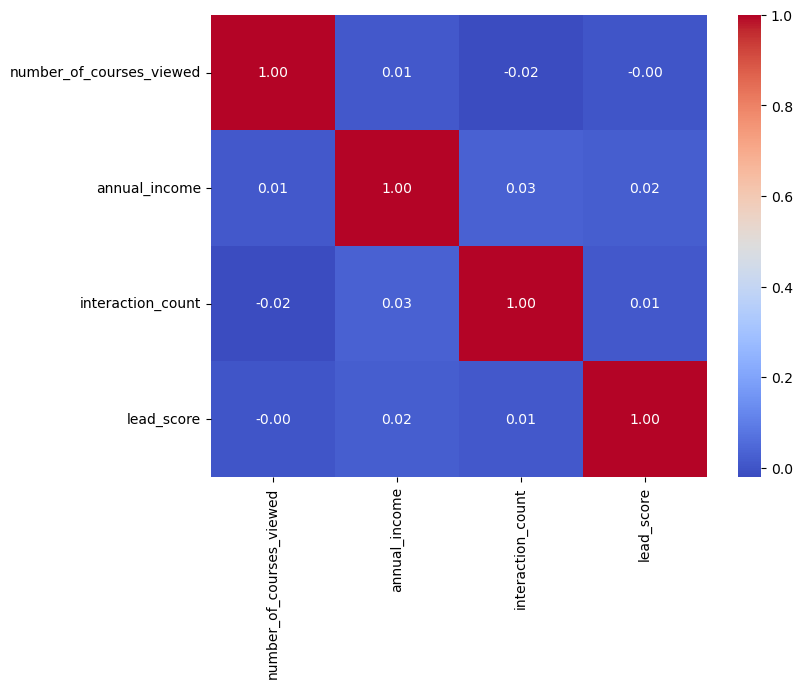

In [54]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

A2: annual_income and interaction_count (correlation=0.03)

## Split the data

- Split your data in train/val/test sets with 60%/20%/20% distribution.
- Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.
- Make sure that the target value y is not in your dataframe.

In [55]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [56]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [57]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [58]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [59]:
del df_train["converted"]
del df_val["converted"]
del df_test["converted"]

## Question 3
- Calculate the mutual information score between y and other categorical variables in the dataset. Use the training set only.
- Round the scores to 2 decimals using round(score, 2).

Which of these variables has the biggest mutual information score?

- industry
- location
- lead_source
- employment_status


In [60]:
def mi_score(series):
    return mutual_info_score(series, df_full_train.converted)

In [61]:
mi = round(df_full_train[categorical].apply(mi_score), 2)
mi.sort_values(ascending=False)

lead_source          0.03
industry             0.01
employment_status    0.01
location             0.00
dtype: float64

A3: lead_source

## Question 4

- Now let's train a logistic regression.
- Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
- Fit the model on the training dataset.
    - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
    - model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
- Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

What accuracy did you get?

In [ ]:
dv = DictVectorizer(sparse_output=False)

dict_train = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(dict_train)

dict_val = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(dict_val)

In [63]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [64]:
y_pred = model.predict(X_val)

In [65]:
accuracy = accuracy_score(y_pred, y_val)
round(accuracy, 2)

0.7

## Question 5

- Let's find the least useful feature using the feature elimination technique.
- Train a model using the same features and parameters as in Q4 (without rounding).
- Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
- For each feature, calculate the difference between the original accuracy and the accuracy without the feature.

Which of following feature has the smallest difference?

- 'industry'
- 'employment_status'
- 'lead_score'


In [66]:
features = df_train.columns.to_list()
features

['lead_source',
 'industry',
 'number_of_courses_viewed',
 'annual_income',
 'employment_status',
 'location',
 'interaction_count',
 'lead_score']

In [ ]:
original_score = accuracy
scores = pd.DataFrame(columns=["eliminated_feature", "accuracy", "absolute_difference"])
results = {}

for feature in features:
    subset = features.copy()
    subset.remove(feature)
    
    dv = DictVectorizer(sparse_output=False)
    train_dict = df_train[subset].to_dict(orient="records")
    X_train = dv.fit_transform(train_dict)
    val_dict = df_val[subset].to_dict(orient="records")
    X_val = dv.transform(val_dict)
    
    model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    
    scores.loc[len(scores)] = [feature, score, abs(original_score - score)]

scores.sort_values("absolute_difference")

,eliminated_feature,accuracy,absolute_difference
1,industry,0.699659,0.000000
4,employment_status,0.696246,0.003413
0,lead_source,0.703072,0.003413
7,lead_score,0.706485,0.006826
5,location,0.709898,0.010239
2,number_of_courses_viewed,0.556314,0.143345
6,interaction_count,0.556314,0.143345
3,annual_income,0.853242,0.153584


A5: industry

## Question 6

- Now let's train a regularized logistic regression.
- Let's try the following values of the parameter C: [0.01, 0.1, 1, 10, 100].
- Train models using all the features as in Q4.
- Calculate the accuracy on the validation dataset and round it to 3 decimal digits.

Which of these C leads to the best accuracy on the validation set?

- 0.01
- 0.1
- 1
- 10
- 100


In [ ]:
C_list = [0.01, 0.1, 1, 10, 100]

dv = DictVectorizer(sparse_output=False)
dict_train = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(dict_train)

dict_val = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(dict_val)

for C in C_list:  
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_pred, y_val)
    print(C, round(accuracy, 3))

0.01 0.7
0.1 0.7
1 0.7
10 0.7
100 0.7


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

# Load dataset
df = pd.read_csv("/Users/musticodes/Desktop/data_ml/03-classification/course_lead_scoring.csv")

# Data preparation: fill missing values
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if "converted" in cat_cols: cat_cols.remove("converted")
if "converted" in num_cols: num_cols.remove("converted")

df[cat_cols] = df[cat_cols].fillna("NA")
df[num_cols] = df[num_cols].fillna(0.0)

# Q1: Mode of 'industry'
q1_mode = df["industry"].mode().iloc[0]

# Q2: Correlation matrix for numeric columns
corr = df[num_cols].corr()
corr_pairs = {
    "interaction_count and lead_score": corr.loc["interaction_count", "lead_score"],
    "number_of_courses_viewed and lead_score": corr.loc["number_of_courses_viewed", "lead_score"],
    "number_of_courses_viewed and interaction_count": corr.loc["number_of_courses_viewed", "interaction_count"],
    "annual_income and interaction_count": corr.loc["annual_income", "interaction_count"]
}
q2_pair = max(corr_pairs, key=lambda x: abs(corr_pairs[x]))

# Split data
X = df.drop(columns=["converted"])
y = df["converted"].astype(int)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

# Q3: Mutual information (categorical vars)
X_train_cat = X_train[cat_cols].apply(lambda col: pd.factorize(col)[0]).astype(int)
mi = mutual_info_classif(X_train_cat, y_train, discrete_features=True, random_state=42)
mi_series = pd.Series(mi, index=cat_cols).round(2)
q3_feature = mi_series.idxmax()

# Q4: Logistic regression accuracy
categorical_features = [c for c in X_train.columns if X_train[c].dtype == "object"]
numeric_features = [c for c in X_train.columns if c not in categorical_features]

preprocessor = ColumnTransformer(
    [("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)],
    remainder="passthrough",
)
model = make_pipeline(preprocessor, LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42))
model.fit(X_train, y_train)
y_val_pred = model.predict(X_val)
q4_acc = round(accuracy_score(y_val, y_val_pred), 2)

# Q5: Feature elimination
baseline_acc = q4_acc
differences = {}
for feat in X_train.columns:
    X_train_sub = X_train.drop(columns=[feat])
    X_val_sub = X_val.drop(columns=[feat])
    cat_sub = [c for c in categorical_features if c != feat]
    preproc_sub = ColumnTransformer(
        [("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_sub)],
        remainder="passthrough",
    )
    model_sub = make_pipeline(preproc_sub, LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42))
    model_sub.fit(X_train_sub, y_train)
    y_val_sub_pred = model_sub.predict(X_val_sub)
    acc_sub = accuracy_score(y_val, y_val_sub_pred)
    differences[feat] = baseline_acc - acc_sub

q5_target_feats = {k: differences.get(k, None) for k in ["industry", "employment_status", "lead_score"]}
q5_feature = min(q5_target_feats, key=lambda k: abs(q5_target_feats[k]) if q5_target_feats[k] is not None else np.inf)

# Q6: Regularized logistic regression (varying C)
Cs = [0.01, 0.1, 1, 10, 100]
accs = {}
for C in Cs:
    model_c = make_pipeline(preprocessor, LogisticRegression(solver="liblinear", C=C, max_iter=1000, random_state=42))
    model_c.fit(X_train, y_train)
    y_val_c = model_c.predict(X_val)
    accs[C] = round(accuracy_score(y_val, y_val_c), 3)
q6_best_C = max(accs, key=lambda c: accs[c])

(q1_mode, q2_pair, q3_feature, q4_acc, q5_feature, q6_best_C, accs)


TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'